# PS Love project

In [3]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from datetime import datetime

Our goal is to infer some pertinent groups of cycles based on their average length, the variability of their lenght, a potential delay, etc...

## Load data

In [4]:
data_directory = "/Users/arthur/hackathon_school_lab/nostalgic_pare/data"
os.listdir(data_directory)

['.DS_Store',
 'Period.csv',
 'clean_period.csv',
 'README.md',
 'clean_symptom.csv',
 'User.csv',
 'df_final.csv',
 'Symptom.csv']

In [5]:
path = os.path.join(data_directory, "df_final.csv")
df_final = pd.read_csv(path)
print(df_final.shape)
print(df_final.columns)
df_final.head()

(13511, 23)
Index(['user_id', 'acne', 'backache', 'bloating', 'cramp', 'diarrhea', 'dizzy',
       'headache', 'mood', 'nausea', 'sore', 'date_clean', 'start_date',
       'end_date', 'cycle_length', 'end_cycle', 'day_of_cycle', 'dob',
       'cycle_length_initial', 'period_length_initial', 'age', 'symptom_id',
       'cycle_id'],
      dtype='object')


,user_id,acne,backache,bloating,cramp,diarrhea,dizzy,headache,mood,nausea,...,end_date,cycle_length,end_cycle,day_of_cycle,dob,cycle_length_initial,period_length_initial,age,symptom_id,cycle_id
0,252,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,28,6,NaN,127,NaN
1,252,50,50,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,28,6,NaN,142,NaN
2,252,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,28,6,NaN,171,NaN
3,254,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,28,6,NaN,135,NaN
4,255,0,0,0,0,0,0,0,100,0,...,NaN,NaN,NaN,NaN,NaN,30,4,NaN,158,NaN


## Cycle clustering

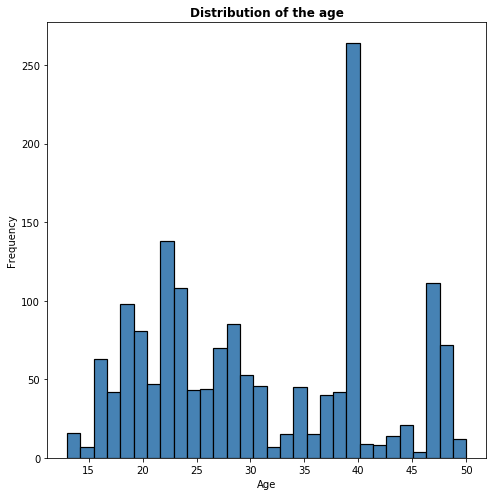

In [6]:
values = np.array(df_final["age"])
values = values[~np.isnan(values)]
plt.figure(figsize=(7, 7))
plt.title("Distribution of the age", fontweight="bold")
plt.hist(values, bins=30, color="steelblue", edgecolor='black', linewidth=1.2)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

We remove duplicate cycles (due to the fact that in df_final one cycle can appear multiple times for different symptoms declaration). Then we compute the delay of each cycle compare to their average lenght, per user.

In [7]:
# remove duplicate cycles
df_lag_period = df_final.loc[:, ["user_id", "cycle_length", "cycle_id"]].drop_duplicates(subset=["user_id", "cycle_id"])

# compute the delay of each cycle
df_lag_period = df_lag_period.assign(
    lag=df_lag_period.loc[:, ["user_id", "cycle_length"]].groupby("user_id").transform(lambda x: x - x.mean()))
df_lag_period = df_lag_period.assign(
    cycle_length_mean=df_lag_period.loc[:, ["user_id", "cycle_length"]].groupby("user_id").transform(lambda x: x.mean()))
df_lag_period = df_lag_period.assign(
    cycle_length_std=df_lag_period.loc[:, ["user_id", "cycle_length"]].groupby("user_id").transform(lambda x: x.std()))

print(df_lag_period.shape)
df_lag_period.head()

(7671, 6)


,user_id,cycle_length,cycle_id,lag,cycle_length_mean,cycle_length_std
0,252,NaN,NaN,NaN,NaN,NaN
3,254,NaN,NaN,NaN,NaN,NaN
4,255,NaN,NaN,NaN,NaN,NaN
5,256,NaN,NaN,NaN,NaN,NaN
6,257,32.0,6.0,0.0,32.0,NaN


We filter the users who registr at least 5 cycles.

In [8]:
df_final = df_final.assign(count=df_final.loc[:, ["user_id", "cycle_length"]].groupby("user_id").count())
values = np.array(df_final.loc[:, "count"])
values[np.isnan(values)] = 0
values += 1
df_final.loc[:, "count"] = values
print(df_final.shape)
df_final.head()

(13511, 24)


,user_id,acne,backache,bloating,cramp,diarrhea,dizzy,headache,mood,nausea,...,cycle_length,end_cycle,day_of_cycle,dob,cycle_length_initial,period_length_initial,age,symptom_id,cycle_id,count
0,252,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,28,6,NaN,127,NaN,1.0
1,252,50,50,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,28,6,NaN,142,NaN,1.0
2,252,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,28,6,NaN,171,NaN,1.0
3,254,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,28,6,NaN,135,NaN,1.0
4,255,0,0,0,0,0,0,0,100,0,...,NaN,NaN,NaN,NaN,30,4,NaN,158,NaN,1.0


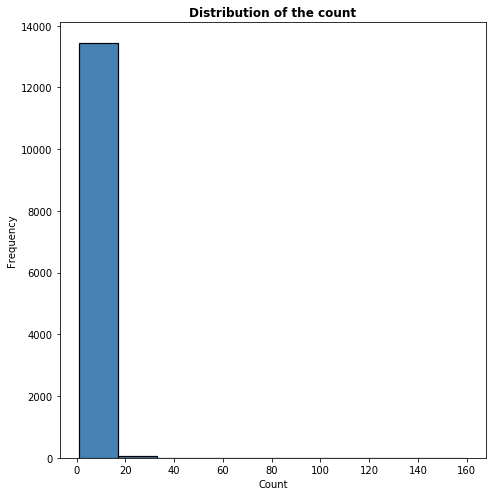

In [9]:
plt.figure(figsize=(7, 7))
plt.title("Distribution of the count", fontweight="bold")
plt.hist(df_final.loc[:, "count"], bins=10, color="steelblue", edgecolor='black', linewidth=1.2)
plt.xlabel("Count")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [10]:
user_frequent = list(df_final.query("count > 5").loc[:, "user_id"])
len(user_frequent)

463

In [11]:
df = df_lag_period.query("user_id in {0}".format(str(user_frequent)))
df = df.dropna()
print(df.shape)
df.head(10)

(1023, 6)


,user_id,cycle_length,cycle_id,lag,cycle_length_mean,cycle_length_std
405,558,24.0,405.0,0.5,23.5,0.707107
406,558,23.0,406.0,-0.5,23.5,0.707107
413,569,27.0,413.0,1.2,25.8,2.683282
414,569,24.0,414.0,-1.8,25.8,2.683282
417,569,22.0,417.0,-3.8,25.8,2.683282
418,569,28.0,418.0,2.2,25.8,2.683282
420,569,28.0,420.0,2.2,25.8,2.683282
450,590,26.0,450.0,0.0,26.0,0.000000
452,590,26.0,452.0,0.0,26.0,0.000000
478,602,16.0,478.0,-8.2,24.2,6.648308


Some distribution plots.

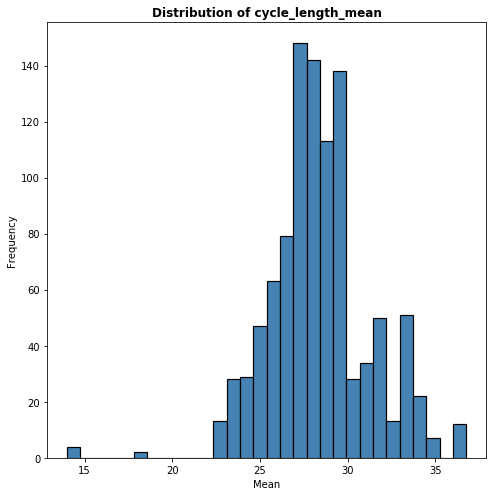

In [12]:
values = np.array(df["cycle_length_mean"])
values = values[~np.isnan(values)]
plt.figure(figsize=(7, 7))
plt.title("Distribution of cycle_length_mean", fontweight="bold")
plt.hist(values, bins=30, color="steelblue", edgecolor='black', linewidth=1.2)
plt.xlabel("Mean")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

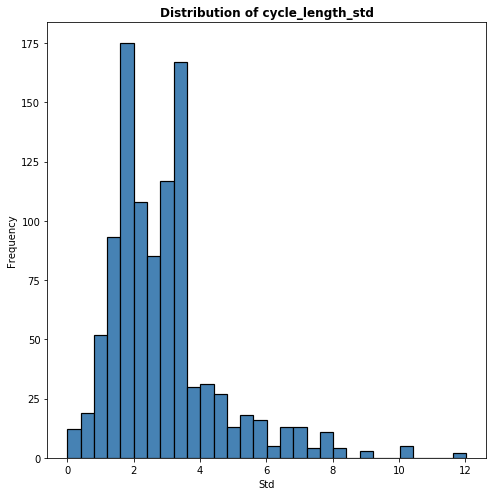

In [13]:
values = np.array(df["cycle_length_std"])
values = values[~np.isnan(values)]
plt.figure(figsize=(7, 7))
plt.title("Distribution of cycle_length_std", fontweight="bold")
plt.hist(values, bins=30, color="steelblue", edgecolor='black', linewidth=1.2)
plt.xlabel("Std")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

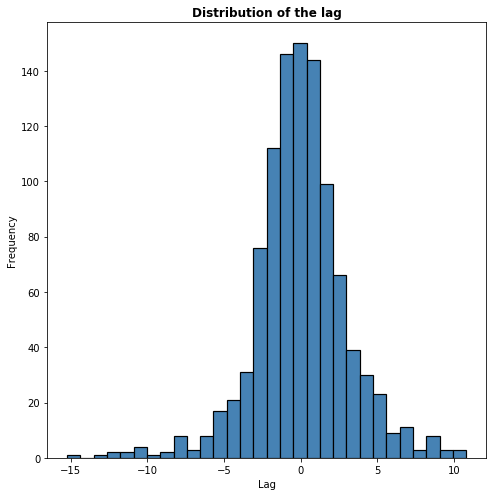

In [14]:
values = np.array(df["lag"])
values = values[~np.isnan(values)]
plt.figure(figsize=(7, 7))
plt.title("Distribution of the lag", fontweight="bold")
plt.hist(values, bins=30, color="steelblue", edgecolor='black', linewidth=1.2)
plt.xlabel("Lag")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

In [15]:
print(df.shape)
df.head()

(1023, 6)


,user_id,cycle_length,cycle_id,lag,cycle_length_mean,cycle_length_std
405,558,24.0,405.0,0.5,23.5,0.707107
406,558,23.0,406.0,-0.5,23.5,0.707107
413,569,27.0,413.0,1.2,25.8,2.683282
414,569,24.0,414.0,-1.8,25.8,2.683282
417,569,22.0,417.0,-3.8,25.8,2.683282


An attempt to add user-related features (age and a priori declarations). It did not improve the clustering.

In [16]:
df_ = df_final.loc[:, ["user_id", "age", 'cycle_length_initial', 'period_length_initial']].drop_duplicates()
print(df_.shape)
df_.head()

(3952, 4)


,user_id,age,cycle_length_initial,period_length_initial
0,252,NaN,28,6
3,254,NaN,28,6
4,255,NaN,30,4
5,256,NaN,25,6
6,257,NaN,30,6


In [17]:
df = pd.merge(df, df_,
              left_on="user_id",
              right_on="user_id",
              how="left")
print(df.shape)
df.head()

(1023, 9)


,user_id,cycle_length,cycle_id,lag,cycle_length_mean,cycle_length_std,age,cycle_length_initial,period_length_initial
0,558,24.0,405.0,0.5,23.5,0.707107,NaN,26,6
1,558,23.0,406.0,-0.5,23.5,0.707107,NaN,26,6
2,569,27.0,413.0,1.2,25.8,2.683282,NaN,28,3
3,569,24.0,414.0,-1.8,25.8,2.683282,NaN,28,3
4,569,22.0,417.0,-3.8,25.8,2.683282,NaN,28,3


Format our input numerical matrix. We rescale it, then we compute a 2D projection using PCA and T-SNE (for visualization purpose). The T-SNE projection works better.

In [21]:
X = df[['lag', 'cycle_length_mean', 'cycle_length_std']].values
X.shape

(1023, 3)

In [22]:
X_scaled = scale(X, axis=0)
pca = PCA(n_components=2, random_state=13)
X_pca = pca.fit_transform(X_scaled)
X_pca.shape

(1023, 2)

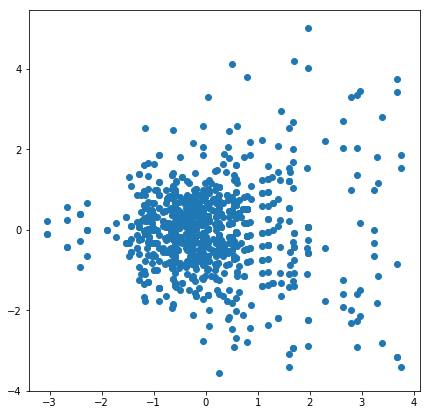

In [23]:
plt.figure(figsize=(7, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.show()

In [24]:
tsne = TSNE(n_components=2, random_state=13)
X_tsne = tsne.fit_transform(X)
X_tsne.shape

(1023, 2)

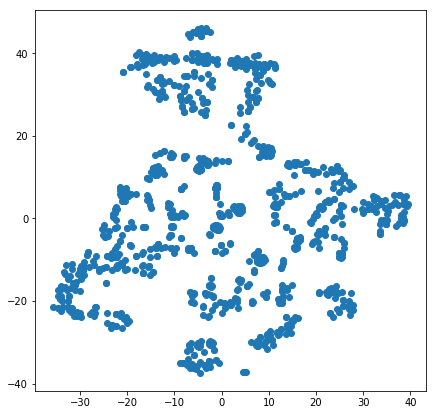

In [25]:
plt.figure(figsize=(7, 7))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], )
plt.show()

Fit a K-means with our data. With a bit of gridsearch, we find 5 pertinents clusters described below.

In [26]:
clf = KMeans(n_clusters=5, random_state=13)
clf.fit(X_scaled)
clusters = clf.predict(X_scaled)
clusters.shape

(1023,)

In [29]:
df.loc[:, "cluster"] = clusters

Some statistical information about our cluster (average lengths of the cycle, standard variation, etc...) to be able to label them.

In [433]:
df.groupby("cluster").count()

,user_id,cycle_length,cycle_id,lag,cycle_length_mean,cycle_length_std,age,cycle_length_initial,period_length_initial
cluster,,,,,,,,,
0,175,175,175,175,175,175,8,175,175
1,84,84,84,84,84,84,6,84,84
2,72,72,72,72,72,72,8,72,72
3,525,525,525,525,525,525,145,525,525
4,167,167,167,167,167,167,11,167,167


In [431]:
df.groupby("cluster").mean()

,user_id,cycle_length,cycle_id,lag,cycle_length_mean,cycle_length_std,age,cycle_length_initial,period_length_initial
cluster,,,,,,,,,
0,2079.611429,24.725714,3667.651429,0.042173,24.683541,2.164761,33.250000,26.948571,5.468571
1,2159.619048,32.202381,3839.392857,4.874251,27.328130,5.852718,31.666667,27.988095,6.059524
2,2077.916667,21.763889,3671.041667,-5.909310,27.673199,5.554204,28.875000,28.402778,6.472222
3,2148.925714,28.419048,3824.022857,-0.010481,28.429529,2.322650,37.082759,27.899048,5.594286
4,2395.497006,33.059880,4388.838323,0.084764,32.975116,2.963545,22.181818,29.526946,5.508982


In [432]:
df.groupby("cluster").std()

,user_id,cycle_length,cycle_id,lag,cycle_length_mean,cycle_length_std,age,cycle_length_initial,period_length_initial
cluster,,,,,,,,,
0,808.554889,2.748912,1755.803886,1.818074,2.061898,1.029291,1.388730,1.498154,1.796512
1,807.479313,3.646354,1756.263874,2.928088,2.094688,1.846365,13.396517,1.972669,2.743453
2,902.031850,4.126497,1974.138260,3.051770,2.300952,1.923266,12.135397,2.476138,3.020923
3,817.505592,2.081273,1777.502831,1.841277,0.952911,0.866531,9.367870,1.357513,1.833001
4,936.810649,3.035335,2053.628127,2.671308,1.506924,0.933087,0.404520,2.973405,1.627580


Our 2D visualization of our data, with the clusters colored. 

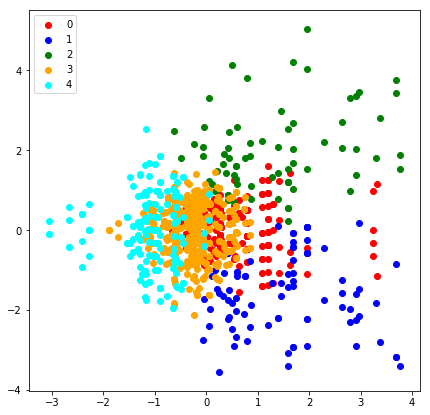

In [27]:
plt.figure(figsize=(7, 7))
c = ["red", "blue", "green", "orange", "cyan"]
for i in range(5):
    plt.scatter(X_pca[clusters == i, 0], X_pca[clusters == i, 1], color=c[i], label=str(i))
plt.legend()
plt.show()

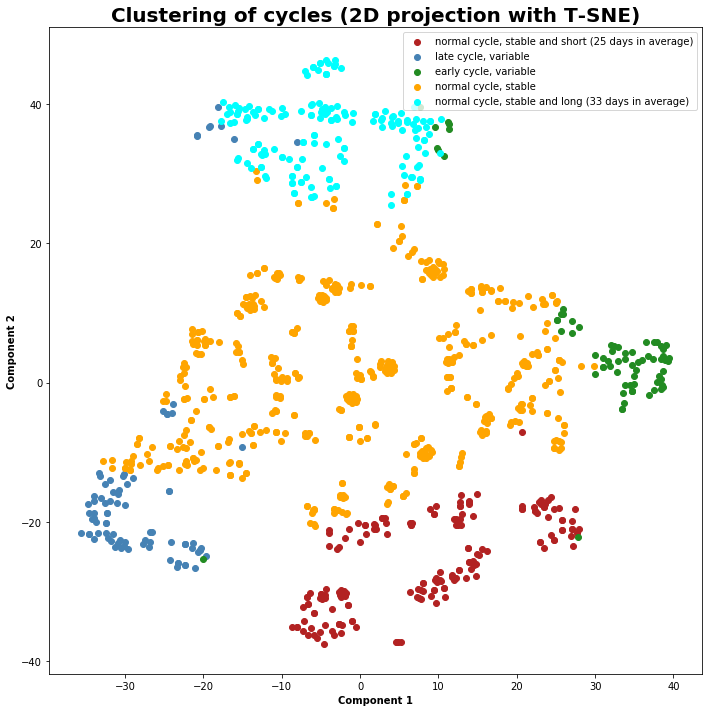

In [34]:
path_output = os.path.join(os.path.dirname(data_directory), "cycle_clustering.png")
plt.figure(figsize=(10, 10))
c = ["firebrick", "steelblue", "forestgreen", "orange", "cyan"]
labels = ["normal cycle, stable and short (25 days in average)", 
          "late cycle, variable", 
          "early cycle, variable", 
          "normal cycle, stable",
          "normal cycle, stable and long (33 days in average)"]
for i in range(5):
    plt.scatter(X_tsne[clusters == i, 0], X_tsne[clusters == i, 1], color=c[i], label=labels[i])
plt.title("Clustering of cycles (2D projection with T-SNE)", fontweight="bold", fontsize=20)
plt.legend()
plt.xlabel("Component 1", fontweight="bold")
plt.ylabel("Component 2", fontweight="bold")
plt.tight_layout()
plt.savefig(path_output)
plt.show()

*Conclusion:*

Our cluster of interest is the blue one, the second one (index = 1). It gathers late cycles but with a higher level of standard deviation. It may regroup some women pregnant. Crossed with additional data (like the symptoms) and with a larger and cleaner dataset some accurate information could be infer about the pregnancy status of an user.

## Can we recognize early pregnancies ?

We want to check if our blue cluster presents a higher level of painful nausea declared. It would be a powerful insight about the pregnancy status of the user, in addition of its late cycle. Unfortunately we did not find any statistical evidence about that pattern.

In [35]:
df_1 = df.query("cluster == 1")
print(df_1.shape)
df_1.head()

(84, 10)


,user_id,cycle_length,cycle_id,lag,cycle_length_mean,cycle_length_std,age,cycle_length_initial,period_length_initial,cluster
10,602,30.0,479.0,5.8,24.2,6.648308,NaN,28,16,1
12,602,28.0,482.0,3.8,24.2,6.648308,NaN,28,16,1
13,602,29.0,484.0,4.8,24.2,6.648308,NaN,28,16,1
29,700,38.0,643.0,4.5,33.5,6.363961,NaN,30,6,1
53,780,35.0,788.0,3.5,31.5,4.949747,NaN,25,5,1


In [46]:
cycle_1 = list(set(df_1["cycle_id"]))
len(cycle_1)

84

In [47]:
df_final.columns

Index(['user_id', 'acne', 'backache', 'bloating', 'cramp', 'diarrhea', 'dizzy',
       'headache', 'mood', 'nausea', 'sore', 'date_clean', 'start_date',
       'end_date', 'cycle_length', 'end_cycle', 'day_of_cycle', 'dob',
       'cycle_length_initial', 'period_length_initial', 'age', 'symptom_id',
       'cycle_id', 'count'],
      dtype='object')

We compute the average value of the declared symptom scores for each cycle (several declarations are possible per cycle). Then we compute a total average for each symptom to get a score per symptom for the full cluster.

In [53]:
df_ = df_final.query("cycle_id in {0}".format(str(cycle_1)))
df_ = df_.loc[:, ['acne', 'backache', 'bloating', 'cramp', 'diarrhea', 'dizzy',
                  'headache', 'mood', 'nausea', 'sore', 'date_clean']].groupby("date_clean").mean()
df_ = df_.replace(0, np.nan)
scores_symptoms = df_.loc[:, ['acne', 'backache', 'bloating', 'cramp', 'diarrhea', 'dizzy',
                              'headache', 'mood', 'nausea', 'sore']].values
print(scores_symptoms.shape)
scores_symptoms_mean = np.nanmean(scores_symptoms, axis=0)
print(scores_symptoms_mean.shape)

(135, 10)
(10,)


In [56]:
scores_symptoms_mean = scores_symptoms_mean.reshape(1, 10)
scores_symptoms_mean

array([[32.49152542, 42.02614379, 45.47522523, 46.86403509, 40.42666667,
        34.63793103, 40.83888889, 50.625     , 42.6       , 46.15306122]])

The result.

In [59]:
features = ['acne', 'backache', 'bloating', 'cramp', 'diarrhea', 'dizzy', 
            'headache', 'mood', 'nausea', 'sore']
pd.DataFrame(scores_symptoms_mean, columns=features)

,acne,backache,bloating,cramp,diarrhea,dizzy,headache,mood,nausea,sore
0,32.491525,42.026144,45.475225,46.864035,40.426667,34.637931,40.838889,50.625,42.6,46.153061
